<h2>Best viewed in <a href="https://nbviewer.jupyter.org/github/codykingham/noun_semantics_SBL18/blob/master/analysis/noun_semantics.ipynb">Jupyter Notebook Viewer</a></h2>

# Noun Semantics in the Hebrew Bible

In this notebook, I compare the syntactic contexts of the top 200 most frequent nouns in the Hebrew Bible. This notebook essentially walks through my process and includes limited commentary throughout. For the fullest commentary on these results, see the paper *[link coming soon -Cody, 16 Nov 2018]*.

In [1]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.app import use

# stats & data-containers
import collections, re, random, csv
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from kneed import KneeLocator # https://github.com/arvkevi/kneed

# data visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
from IPython.display import HTML, display

# custom modules
from pyscripts.contextcount import ContextCounter, ContextTester
from pyscripts.contextparameters import deliver_params

# prep the Hebrew syntax data

name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'phono')] # data dirs
load_features = '''
heads typ phono lex_utf8 lex
voc_lex_utf8 voc_lex gloss
freq_lex pdp sp ls
language
prep_obj rela number function
vs vt
''' 
# TF load statements
TF = Fabric(locations=hebrew_data)
api = TF.load(load_features)
B = use('bhsa', api=api, hoist=globals(), silent=True) # Bhsa functions for search and visualizing text

This is Text-Fabric 7.3.4
Api reference : https://{ORG}.github.io/{REPO}/Api/Fabric/

120 features found and 0 ignored
  0.00s loading features ...
   |     0.11s B lex                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.15s B lex_utf8             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.18s B phono                from /Users/cody/github/etcbc/phono/tf/c
   |     0.00s B voc_lex_utf8         from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.71s B heads                from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.19s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.00s B voc_lex              from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.00s B gloss                from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.08s B freq_lex             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B pdp                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B sp                   from /Users/cody/github/et

In [2]:
def reverse_hb(heb_text):
    '''
    Reverses order of left-to-right text 
    for good matplotlib formatting.
    '''
    return ''.join(reversed(heb_text))

def show_word_list(word_nodes, joiner='&nbsp;&nbsp;|', title=''):
    '''
    Displays Hebrew for a pipe-separated list of word nodes
    Good for seeing lexemes without taking up screen space.
    '''
    formatted = joiner.join(B.plain(node, _asString=True, withPassage=False) for node in word_nodes)
    display(HTML(formatted))

## Demonstrating the Collocational Principle

Here is a query for all nouns that serve as the object to the verb אכל "to eat". This query demonstrates how the collocation patterns of syntactic context can be informative for semantic meaning. This is the driving principle behind this project.

In [3]:
eat_obj = '''

clause
    phrase function=Pred
        word pdp=verb lex=>KL[
    phrase function=Objc
        -heads> w1:word pdp=subs
        
lex
    w2:word
    
w1 = w2
'''

eat_obj = B.search(eat_obj)
eaten_lexs = collections.Counter(T.text(r[5]) for r in eat_obj)

for word, count in eaten_lexs.most_common(10):
    print(f'{count}\t{word}')

  1.54s 280 results
59	לֶחֶם 
21	בָּשָׂר 
17	פְּרִי 
14	מַצָּה 
10	אַרְמֹון 
9	דָּם 
5	נְבֵלָה 
5	דְּבַשׁ 
4	חֵלֶב 
4	קֹדֶשׁ 


In [4]:
len(list(F.otype.s('word')))

426584

## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

In [5]:
raw_search = '''

lex language=Hebrew sp=subs

'''

raw_nouns = B.search(raw_search)

  0.05s 3706 results


Now we order the results on the basis of lexeme frequency.

In [6]:
raw_terms_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in raw_nouns), reverse=True)

Below we have a look at the top 50 terms from the selected set. Pay attention to the feature `ls`, i.e. "lexical set." This feature gives us some rudimentary semantic information about the nouns and their usual functions, and it suggests that some additional restrictions are necessary for the noun selection procedure. Note especially that several of these nouns are used in adjectival or prepositional roles (e.g.  כל ,אחד, אין, תחת).

In [7]:
raw_nnodes = [res[1] for res in raw_terms_ordered] # isolate the word nodes of the sample
B.displaySetup(extraFeatures={'ls', 'freq_lex'}) # config B to display ls and freq_lex



# display lexeme data
for i, node in enumerate(raw_nnodes[:50]):
    B.prettyTuple((node,), seqNumber=i)



**Result** *0*





**Result** *1*





**Result** *2*





**Result** *3*





**Result** *4*





**Result** *5*





**Result** *6*





**Result** *7*





**Result** *8*





**Result** *9*





**Result** *10*





**Result** *11*





**Result** *12*





**Result** *13*





**Result** *14*





**Result** *15*





**Result** *16*





**Result** *17*





**Result** *18*





**Result** *19*





**Result** *20*





**Result** *21*





**Result** *22*





**Result** *23*





**Result** *24*





**Result** *25*





**Result** *26*





**Result** *27*





**Result** *28*





**Result** *29*





**Result** *30*





**Result** *31*





**Result** *32*





**Result** *33*





**Result** *34*





**Result** *35*





**Result** *36*





**Result** *37*





**Result** *38*





**Result** *39*





**Result** *40*





**Result** *41*





**Result** *42*





**Result** *43*





**Result** *44*





**Result** *45*





**Result** *46*





**Result** *47*





**Result** *48*





**Result** *49*



Based on the nouns that are present, we should make some key exclusions. Many substantives have more functional or adjectival roles. Undesirable categories include copulative nouns (`nmcp`, e.g. אין), cardinal numbers (`card`), potential prepositions (`ppre`, e.g. תחת). The `ls` category of potential adverb (`padv`) contains desirable nouns like יום, but also more functionally adverbial-nouns like עוד. Thus we can see that there is a range of adverbial tendencies found in this category. Due to the potentially interesting possibility of seeing these tendencies play out in the data, we can decide to keep these instances. 

To be sure, the very phenomenon of "functional" versus "nominal" is worthy of further, quantitative investigation. The `ls` feature is an experimental and incomplete feature in the ETCBC, and this is precisely the kind of shortcoming this present work seeks to address. Nouns and adverbs likely sit along a sliding scale of adverbial tendencies, with adverbs nearly always functioning in such a role, and nouns exhibiting various statistical tendencies. But due to the scope of this investigation, we limit ourselves to mainly nominal words with a small inclusion of some adverbial-like substantives.

We can eliminate more functional nouns by restricting the possible lexical set (`ls`) values. Below we apply those restrictions to the search template. In the case of certain quantifiers such as כל there is an `ls` feature of distributive noun (`nmdi`), yet this feature is likewise applied to nouns such as אח ("brother"). So it is undesirable to exclude all of these cases. Thus we depend, instead, on an additional filter list that excludes quantifiers.

A few terms such as דרך and עבר are eliminated because the ETCBC labels it as a potential preposition. This is a speculative classification. So we define a seperate parameter in the template that saves this instance.

In [8]:
exclude = '|'.join(('KL/', 'M<V/', 'JTR/', 'M<FR/', 'XYJ/')) # exclude quantifiers
include = '|'.join(('padv', 'nmdi'))  # ok ls features
keep = '|'.join(('DRK/', '<BR/'))

'''
Below is a TF search query for three cases:
One is a lexeme with included ls features.
The second is a lexeme with a null ls feature.
The third is lexemes we want to prevent from being excluded.
For all cases we exclude excluded lexemes.
'''

select_noun_search = f'''

lex language=Hebrew
/with/
sp=subs ls={include} lex#{exclude}
/or/
sp=subs ls# lex#{exclude}
/or/
sp=subs lex={keep}
/-/

'''

select_nouns = B.search(select_noun_search)
noun_dat_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in select_nouns), reverse=True)
nnodes_ordered = list(noun_dat[1] for noun_dat in noun_dat_ordered)
filtered_lexs = list(node for node in raw_nnodes if node not in nnodes_ordered)

print(f'\t{len(raw_nouns) - len(select_nouns)} results filtered out of raw noun list...')
print('\tfiltered lexemes shown below:')
show_word_list(filtered_lexs)

  0.02s 3658 results
	48 results filtered out of raw noun list...
	filtered lexemes shown below:


### Plot the Nouns in Order of Frequency

Now that we have obtained a filtered noun-set, we must decide a cut-off point at which to limit the present analysis. Below we plot the attested nouns and their respective frequencies.

[]

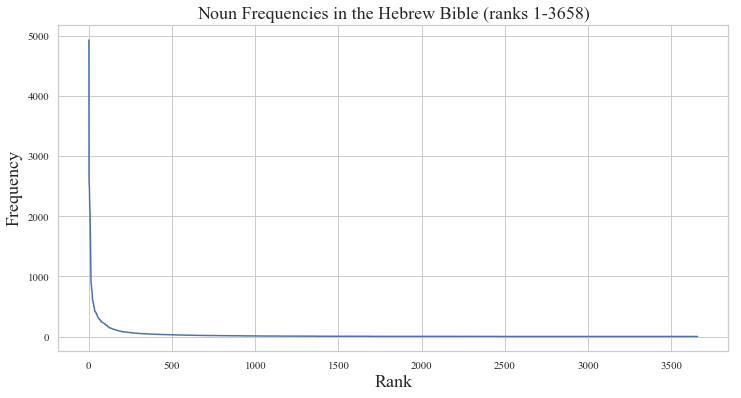

In [9]:
# plot data
y_freqs = [lex_data[0] for lex_data in noun_dat_ordered]
x_rank = [i+1 for i in range(0, len(y_freqs))]
title = 'Noun Frequencies in the Hebrew Bible'
xlabel = 'Rank'
ylabel = 'Frequency'

# first plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank, y_freqs)
plt.title(title + f' (ranks 1-{len(x_rank)})', size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

We zoom in closer to view ranks 1-1000...

*Consider using a subplot here with 4 different zooms*

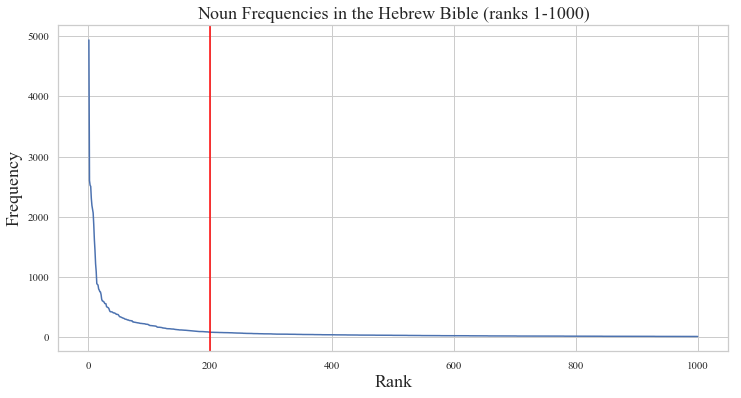

In [10]:
# second plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank[:1000], y_freqs[:1000])
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.axvline(200, color='red')
plt.savefig('plots/noun_frequencies1-1000.png', dpi=300, bbox_inches='tight') # save the plot (without title)
plt.title(title + f' (ranks 1-1000)', size=18)
plt.show()

This curve is typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve sharply "elbows" at around rank 15. Between ranks 50-100 there is still an appreciable drop-off. The curve starts to significantly flatten after 200. We thus decide an arbitrary cut-off point at rank 200, based on the fact that the curve does not show any significant leveling after this point.

In [11]:
target_nouns = nnodes_ordered[:200]
tnoun_instances = set(word for lex in target_nouns for word in L.d(lex, 'word'))

show_word_list(target_nouns) # temporary comment out while bug is fixed
print(f'\n{len(tnoun_instances)} nouns ready for searches')


73991 nouns ready for searches


## Strategy for Context Selection

See [pyscripts/contextparameters.py](pyscripts/contextparameters.py) for the full delineation of these patterns and to see how they've been selected and tokenized. **This is a work in progress.**

* phrase-type relations
    * PP and their objcs

* subphrase relations
    * parallel (`par`) — syndetic connections
    * regens/rectum (`rec`) — nomen regens/rectum relations
    * adjunct (`adj`)
    * attribute (`atr`)
    

* phrase_atom relations
    * apposition (`appo`) — re-identification relations
    * parallel and link, what is the difference here?
    * specification, what is it?
    
    
* clause-constituent relations
    * "is a" relations with היה (subjects || predicate complements)
    * all other predicate / function roles — FRAMES

In [12]:
contexts = deliver_params(tnoun_instances, tf=api)

In [13]:
print('The following contextual relations will be queried (. without lex = target noun; -> = relation):')
for i, param in enumerate(contexts):
    name = param['name']
    print(f'{i+1}. {name}')

The following contextual relations will be queried (. without lex = target noun; -> = relation):
1. funct.-> st.verb.lex
2. funct.prep-> st.verb.lex
3. PreC.lex-> Subj.
4. PreC.prep.lex-> Subj.
5. PreC.-> Subj.lex
6. PreC.prep. -> Subj.lex
7. par.lex-> .
8. par.-> lex
9. atr.lex -> .
10. rec.lex -> .
11. rec.-> lex
12. Para.lex-> .
13. Para.-> lex
14. Appo.lex-> .
15. Appo.-> lex


In [14]:
counts = ContextCounter(contexts, tf=api, report=True)

running query on template [ funct.-> st.verb.lex ]...
	19276 results found.
running query on template [ funct.prep-> st.verb.lex ]...
	14935 results found.
running query on template [ PreC.lex-> Subj. ]...
	2559 results found.
running query on template [ PreC.prep.lex-> Subj. ]...
	1125 results found.
running query on template [ PreC.-> Subj.lex ]...
	950 results found.
running query on template [ PreC.prep. -> Subj.lex ]...
	1488 results found.
running query on template [ par.lex-> . ]...
	2121 results found.
running query on template [ par.-> lex ]...
	2037 results found.
running query on template [ atr.lex -> . ]...
	1507 results found.
running query on template [ rec.lex -> . ]...
	1435 results found.
running query on template [ rec.-> lex ]...
	1692 results found.
running query on template [ Para.lex-> . ]...
	669 results found.
running query on template [ Para.-> lex ]...
	596 results found.
running query on template [ Appo.lex-> . ]...
	1410 results found.
running query on templ

<hr>

### Excursus: Checking Context Tags and Gathering Examples

In this section I will inspect the tokens that are generated and counted, as well as pull out some examples and their counts for the presentation.

In [15]:
patterns = {'funct.-> st.verb.lex': '\D*\.-> \D*\.\D*\[',
            'funct.prep-> st.verb.lex': '\D*\.\D+\-> \D*\.\D*\['}

token_examps = collections.defaultdict(list)

for token in counts.data.index:
    for query, pattern in patterns.items():
        if re.match(pattern, token):
            token_examps[query].append(token)

for query in token_examps:
    random.shuffle(token_examps[query])
    examples = token_examps[query][:10]
    targets = list()
    
    # get example target nouns
    for ex in examples:
        ex_target = counts.data.loc[ex].sort_values(ascending=False).index[0]
        targets.append(ex_target)
        
    show_random = [f'target: {target} \t {ex}' for target, ex in zip(targets, examples)]
    
    print('QUERY: ', query)
    print('-'*5)
    print('\n'.join(show_random))
    print('-'*20, '\n')

QUERY:  funct.-> st.verb.lex
-----
target: <M/ 	 Objc.-> qal.BWS[
target: <WD/ 	 Modi.-> hif.BW>[
target: >CH/ 	 Objc.-> piel.VM>[
target: PH/ 	 Modi.-> piel.ML>[
target: <WD/ 	 Modi.-> hif.QCH[
target: M>D/ 	 Modi.-> qal.XPY[
target: GWJ/ 	 Subj.-> nif.LWH[
target: JWM/ 	 Time.-> qal.>SP[
target: JWM/ 	 Time.-> hit.NPL[
target: <WD/ 	 Modi.-> hif.JNH[
-------------------- 

QUERY:  funct.prep-> st.verb.lex
-----
target: FR/ 	 Cmpl.>L-> nif.KTB[
target: PNH/ 	 Adju.<L-> piel.<PP[
target: BN/ 	 Cmpl.L-> qal.XWD[
target: >L/ 	 Cmpl.>L-> piel.RNN[
target: MQWM/ 	 Cmpl.B-> piel.CKN[
target: ZRW</ 	 Cmpl.MN-> piel.CW<[
target: JWM/ 	 Time.MN-> qal.HLK[
target: >LHJM/ 	 Adju.B-> hit.BRK[
target: <JR/ 	 Cmpl.>L-> qal.NWS[
target: MJM/ 	 Loca.<L-> qal.RJB[
-------------------- 



Now some more specific counts...

In [16]:
counts.data['LB/']['Objc.-> piel.ZKH['].sum()

1.0

In [17]:
counts.data['PTX/']['Cmpl.-> qal.<MD['].sum()

10.0

In [18]:
counts.data['>JC/']['Subj.-> hit.PQD['].sum()

2.0

In [19]:
counts.data['C<R/']['Loca.-> qal.CJT['].sum()

1.0

In [20]:
counts.data['GWJ/']['Adju.B-> qal.>MR['].sum()

2.0

In [21]:
counts.data['JD/']['Cmpl.MN-> hif.JC<['].sum()

17.0

In [22]:
counts.data['<T/']['Time.B-> nif.NTN['].sum()

1.0

In [23]:
counts.data['DRK/']['Cmpl.L-> qal.PNH['].sum()

1.0

<hr>

#### Examining the Dataset

Below we look at the number of dimensions in the data:

In [24]:
counts.data.shape

(13714, 199)

And a sample of the data is below:

In [25]:
counts.data.head()

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.<LH[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.<TR[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.BW>[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.CLK[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.JBL[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that one of the original target lexemes have been omitted because they fell below the 10 observation threshold. Let's see which ones they are.

In [26]:
set(F.lex.v(w) for w in tnoun_instances) - set(F.lex.v(counts.target2node[token]) for token in counts.data.columns)

{'N>M/'}

The noun נאֻם is omitted due to lack of relevant data. We thus continue with **199 target nouns.**

Next we look at a few example counts:

In [27]:
counts.data['>LHJM/'][counts.data['>LHJM/'] > 0].sort_values(ascending=False)

Appo.-> JHWH/              730.0
atr.>XR=/-> .               61.0
Subj.-> qal.>MR[            50.0
Subj.-> qal.NTN[            32.0
Objc.-> qal.<BD[            29.0
Subj.-> qal.<FH[            23.0
Appo.-> >LHJM/              18.0
Appo.>LHJM/-> .             18.0
Cmpl.>XR/-> qal.HLK[        15.0
Objc.-> qal.JR>[            13.0
Subj.-> qal.R>H[            13.0
Subj.-> piel.DBR[           12.0
PreC.-> Subj.JHWH/          11.0
Subj.-> qal.CM<[            10.0
Objc.-> qal.<FH[             9.0
Subj.-> piel.BRK[            9.0
Appo.-> PNH/                 8.0
Subj.-> hif.NYL[             8.0
Subj.-> qal.BW>[             8.0
Cmpl.>L-> qal.>MR[           8.0
Subj.-> piel.YWH[            7.0
Subj.-> qal.CLX[             7.0
Cmpl.L-> piel.QVR[           7.0
Cmpl.B-> qal.C>L[            7.0
Objc.-> piel.BRK[            7.0
Objc.-> qal.DRC[             7.0
Subj.-> qal.BR>[             6.0
Appo.-> BJT/                 6.0
Objc.-> qal.R>H[             6.0
Cmpl.L-> qal.ZBX[            6.0
          

This gives a good idea of the content of the co-occurrence counts.

#### Various Tag Searches Below

Below I isolate a few tags of interest to serve as examples in the paper. 

**TODO:** Extract and display all the exact examples.

In [28]:
prec = [tag for tag in counts.data.index if 'PreC' in tag and '>JC/' in tag]

prec

['PreC.-> Subj.>JC/',
 'PreC.<L. -> Subj.>JC/',
 'PreC.<L.>JC/-> Subj.',
 'PreC.>JC/-> Subj.',
 'PreC.>L. -> Subj.>JC/',
 'PreC.>T==. -> Subj.>JC/',
 'PreC.B. -> Subj.>JC/',
 'PreC.DRK/. -> Subj.>JC/',
 'PreC.K. -> Subj.>JC/',
 'PreC.K.>JC/-> Subj.',
 'PreC.L. -> Subj.>JC/',
 'PreC.L.>JC/-> Subj.',
 'PreC.MN. -> Subj.>JC/']

In [31]:
target = '<LH/'

target_counts = counts.data[target][counts.data[target]>0].sort_values(ascending=False)

prec_contexts = target_counts[target_counts.index.str.contains('PreC.L.')]

prec_contexts

PreC.-> Subj.QRBN/       2.0
PreC.L.RYWN/-> Subj.     2.0
PreC.>JL=/-> Subj.       1.0
PreC.KBF/-> Subj.        1.0
PreC.L. -> Subj.>LH      1.0
PreC.L. -> Subj.>XD/     1.0
PreC.L.NGD/-> Subj.      1.0
PreC.L.RB=/-> Subj.      1.0
PreC.B. -> Subj.XPY/     1.0
PreC.<L.NFJ>/-> Subj.    1.0
Name: <LH/, dtype: float64

In [79]:
import re

In [110]:
[res for res in counts.data.index if re.findall('PreC\.. ->', res)][:10]

[]

In [98]:
counts.data.loc['PreC.-> Subj.>T.KLJ/'].sort_values(ascending=False).head(5)

NXCT/    1.0
RB=/     0.0
JJN/     0.0
>B/      0.0
ML>K/    0.0
Name: PreC.-> Subj.>T.KLJ/, dtype: float64

In [85]:
B.show(counts.target2basis2result['JD/']['Cmpl.MN-> hif.JC<['], condenseType='clause')



**clause** *1*





**clause** *2*





**clause** *3*





**clause** *4*





**clause** *5*





**clause** *6*





**clause** *7*





**clause** *8*





**clause** *9*





**clause** *10*





**clause** *11*





**clause** *12*





**clause** *13*





**clause** *14*





**clause** *15*





**clause** *16*





**clause** *17*



## Adjusting the Counts

We will apply two primary adjustments:

1. We drop co-occurrences that are unique to a noun. The dropped observations will thus be considered outliers. While these items are useful for describing the uniqueness of a given lexeme, they are unhelpful for drawing comparisons between our sets. 
2. We convert the counts into a measure of statistical significance. For this we use Fisher's exact test, which is ideal for datasets that have counts that are less than 5. Our matrix is likely to have many such counts. The resulting p-values, of which <0.05 represents a statistically significant colexeme, will be log-transformed. Values that fall below expected frequencies will be negatively transformed.

### Remove Co-occurrence Outliers

We will remove colexemes/bases that occur with only one target noun. This is done by subtracting the row total from each item in the row. Any 0 value in a row means that that row has a unique colexeme that only occurs with one target noun (we will call that a `hapax_colex` here). We will remove these rows further down.

In [34]:
colex_counts = counts.data.sum(1)
remaining_counts = counts.data.sub(colex_counts, axis=0) # subtract colex_counts
hapax_colex = remaining_counts[(remaining_counts == 0).any(1)] # select rows that have a 0 value anywhere

Below is an example just to make sure we've selected the right indices. The value has been manually chosen from `hapax_colex`.

In [35]:
counts.data.loc['rec.XTN/-> .'].sort_values(ascending=False).head()

QWL/     8.0
RB=/     0.0
JJN/     0.0
>B/      0.0
ML>K/    0.0
Name: rec.XTN/-> ., dtype: float64

Indeed this basis element is only attested with קול, thus it is not useful for drawing meaningful comparisons to this noun. Below we see that there are `8191` other such basis elements. We remove these data points in the next cell and name the new dataset `data`.

In [36]:
hapax_colex.shape

(9442, 199)

In [37]:
data = counts.data.drop(labels=hapax_colex.index, axis=0)

print(f'New data dimensions: {data.shape}')
print(f'New total observations: {data.sum().sum()}')
print(f'Observations removed: {counts.data.sum().sum() - data.sum().sum()}')

New data dimensions: (4272, 199)
New total observations: 42077.0
Observations removed: 13360.0


Random example to make sure there are no unique colexemes in the new dataset:

In [38]:
data.loc['Adju.-> hif.BW>['].sort_values(ascending=False).head(5)

KLJ/     1.0
ZHB/     1.0
>JL=/    1.0
KSP/     1.0
RB=/     0.0
Name: Adju.-> hif.BW>[, dtype: float64

#### Check for Orphaned Target Nouns

I want to see if any target nouns in the dataset now have 0 basis observations (i.e. "orphaned") as a result of our data pruning. The test below shows that there is no columns in the table with a sum of 0.

In [39]:
data.loc[:, (data == 0).all(0)].shape

(4272, 0)

### Apply Fisher's Exact Test

Now we apply the Fisher's exact test to the data set. This involves supplying values to a 2x2 contingency table that is fed to `scipy.stats.fisher_exact`

In [40]:
# data for contingency tables
target_obs = data.apply(lambda col: col.sum(), axis=0, result_type='broadcast') # total target lexeme observations
colex_obs = data.apply(lambda col: col.sum(), axis=1, result_type='broadcast') # total colexeme/basis observations
total_obs = data.sum().sum() # total observations

# parts of contingency formula; a=data
b_matrix = target_obs.sub(data)
c_matrix = colex_obs.sub(data)
d_matrix = pd.DataFrame.copy(data, deep=True)
d_matrix[:] = total_obs
d_matrix = d_matrix.sub(data+b_matrix+c_matrix)

fisher_transformed = collections.defaultdict(lambda: collections.defaultdict())

i = 0
for lex in data.columns:
    for colex in data.index:
        a = data[lex][colex]
        b = b_matrix[lex][colex]
        c = c_matrix[lex][colex]
        d = d_matrix[lex][colex]
        contingency = np.matrix([[a, b], [c, d]])
        oddsratio, pvalue = stats.fisher_exact(contingency)
        fisher_transformed[lex][colex] = pvalue
        i += 1
        if i % 100000 == 0: # update every 100,000 iterations; should be 850,128 total (4272x199)
            print(f'finished iteration {i}...')
print(f'DONE at iteration {i}!')

fisherdata = pd.DataFrame(fisher_transformed)

finished iteration 100000...
finished iteration 200000...
finished iteration 300000...
finished iteration 400000...
finished iteration 500000...
finished iteration 600000...
finished iteration 700000...
finished iteration 800000...
done!


In [41]:
fisherdata.head(10)

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.BW>[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> hif.NKH[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> nif.>SP[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> nif.CMM[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> piel.DBR[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.<BD[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.021874,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.<FH[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.HLK[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.JCB[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Adju.-> qal.JLD[,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.030626,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Now we apply the log10 transformation.

In [42]:
expectedfreqs = (data+b_matrix) * (data+c_matrix) / (data+b_matrix+c_matrix+d_matrix)
fishertransf = collections.defaultdict(lambda: collections.defaultdict())

for lex in data.columns:
    for colex in data.index:
        observed_freq = data[lex][colex]
        exp_freq = expectedfreqs[lex][colex]
        pvalue = fisherdata[lex][colex]
        if observed_freq < exp_freq:
            logv = np.log10(pvalue)
            fishertransf[lex][colex] = logv
        else:
            logv = -np.log10(pvalue)
            fishertransf[lex][colex] = logv
            
fishertransf = pd.DataFrame(fishertransf)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


The Fisher's test has produced a zero value, indicating a very high degree of attraction between a lexeme and a colexeme. A log-transformed zero equals `infinity`. Below that value is isolated to the target noun אלהים and its colexeme יהוה used in an appositional relation. This makes complete sense given the identity of these two nouns in the Hebrew Bible.

In [43]:
fishertransf[(fishertransf == np.inf).any(1)]

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Appo.-> JHWH/,inf,-10.619133,-0.190784,-7.52451,-0.55876,-1.065681,-2.275035,-0.742157,-1.416988,-3.136365,...,-0.18751,0.0,-0.190784,-1.435602,-0.197795,0.0,-0.74712,-0.195501,-0.191807,-0.2014


In this case the Fisher's has returned a zero value. A p-value of 0 means that the likelihood אלהים and יהוה are *not* dependent variables is essentially null. We can thus reject the null hypothesis that the two values are not related. There is, rather, a maximum level of confidence that these two values *are* interrelated. The `np.inf` value that resulted from `log10(0)` is not viable for calculating vector distances. Thus, we need to substitute an arbitrary, but appropriate value. Below we access the lowest p-values in the dataset.

In [44]:
fisherdata.min().sort_values().head(5)

>LHJM/     0.000000e+00
QWL/      5.052305e-187
JD/       2.119641e-172
CM/       3.332959e-159
BRJT/     2.173158e-128
dtype: float64

As indicated, קול has the lowest possible p-value. Let's look at its associated basis elements.

In [45]:
fisherdata['QWL/'].sort_values().head(10)

Cmpl.B-> qal.CM<[    5.052305e-187
Objc.-> qal.CM<[      1.984544e-76
par.QWL/-> .          1.519595e-54
par.-> QWL/           2.256781e-53
Subj.-> nif.CM<[      2.571659e-37
Cmpl.L-> qal.CM<[     1.128905e-26
Objc.-> hif.CM<[      3.638036e-17
atr.GDWL/-> .         6.679296e-17
rec.FMXH/-> .         1.711939e-15
Objc.-> hif.RWM[      1.567076e-13
Name: QWL/, dtype: float64

These values are greatly expected to be associated with קול ("voice/sound". For instance, the term is used frequently as a complement, object, and subject of various stems of שמע ("to hear/cause to be heard"). It is also used in construct with שמחה ("joy").

Since `Cmpl.B-> qal.CM<[` has the lowest p-value in the dataset (an extremely tiny number: 3.702549 preceded by 185 zeros), it is an appropriate substitute for the p-value of 0 found between אלהים and its appositional יהוה. We make the substitution below for both `fisherdata` and the log-transformed p-values in `fishertransf`.

In [46]:
fisherdata['>LHJM/']['Appo.-> JHWH/'] = fisherdata['QWL/']['Cmpl.B-> qal.CM<[']
fishertransf['>LHJM/']['Appo.-> JHWH/'] = fishertransf['QWL/']['Cmpl.B-> qal.CM<[']

for change in (fisherdata['>LHJM/']['Appo.-> JHWH/'], fishertransf['>LHJM/']['Appo.-> JHWH/']):
    print(change)

5.052305378454621e-187
186.29651040709345


In [47]:
fishertransf.head()

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.BW>[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.NKH[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> nif.>SP[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> nif.CMM[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> piel.DBR[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>

#### Excursus: A Random Sample Examined

We saw that the model seems to be succeeding at isolating intuitive associations with קול. Let's look at another example at random, in this case the noun ארץ ("land"). Below are the transformed p-values for that noun.

In [48]:
fishertransf['>RY/'].sort_values(ascending=False).head(10)

Objc.-> qal.JRC[      51.058268
Cmpl.MN-> hif.JY>[    39.380650
rec.-> <M/            35.542862
rec.-> JCB[           25.669228
rec.-> MMLKH/         25.406027
Cmpl.MN-> hif.<LH[    23.616585
Cmpl.B-> qal.JCB[     20.285650
Appo.>RY/-> .         15.151985
Cmpl.>L-> hif.BW>[    13.586606
Appo.-> >RY/          13.581480
Name: >RY/, dtype: float64

The most associated variables include cases where ארץ is an object to the verb ירשׁ, where ארץ serves as the complement from which something is brought (hifil of יצא and hifil of עלה), frequently in construct to >M (עם, "people"), JCB (probably the participle of ישב, "inhabitant(s)"), and MMlH (ממלכה, "kingdom"), as well as other satisfying and expected occasions of use. These examples show that the model is working well.
<hr>

## Comparing the Nouns

The nouns are now ready to be compared. I will do so in two ways.

1. Principle Component Analysis — We have a semantic space with 4,272 dimensions. That is a lot of potential angles from which to compare the vectors. One method that is commonly used in semantic space analysis is principle component analysis or **PCA**. PCA is a dimensionality reduction method that reduce a multi-dimensional vector to the two points in an imagined space that show the most distance between the nouns. We can visualize said space by plotting the two points on an X and Y axis.
2. Cosine Similarity — This measure allows us to compare the vectors on the basis of their trajectories. This method is particularly well-suited for semantic spaces because it ignores differences in frequency and compares, rather, the closeness of relationship between two sets of frequencies. 

### PCA Analysis

We want to apply PCA in order to plot nouns in an imaginary space. The goal is to use the visualization to identify patterns and groups amongst the 199 target nouns. Nouns that are more similar should fall within the same general areas relative to the origin (0, 0). PCA seeks to identify the maximum variance amongst the vector spaces. 

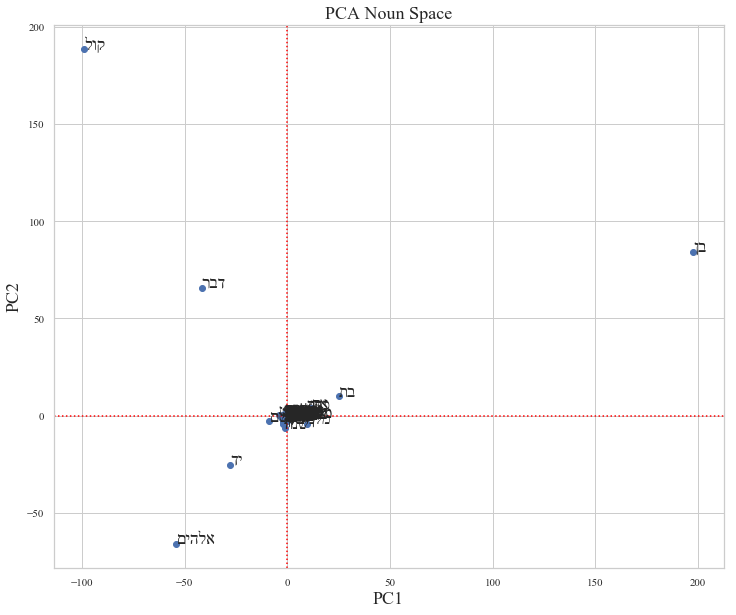

In [49]:
pca = PCA(3) # PCA with 3 principal components
pca_nouns = pca.fit_transform(fishertransf.T.values) # get coordinates


def plot_PCA(pca_nouns, zoom=tuple(), noun_xy_dict=False, save=''):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    # plot coordinates
    plt.figure(figsize=(12, 10))
    plt.scatter(pca_nouns[:, 0], pca_nouns[:, 1])

    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        
    plt.title('PCA Noun Space', size=18)
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')

    # annotate points
    noun_xy = {} # for noun_dict
    noun_lexs = [f'{reverse_hb(F.lex_utf8.v(counts.target2node[n]))}' for n in fishertransf.columns]
    for i, noun in enumerate(noun_lexs):
        x, y = pca_nouns[i, 0], pca_nouns[i, 1]
        noun_xy[fishertransf.columns[i]] = (x, y)
        if zoom: # to avoid annotating outside of field of view (makes plot small)
            if any([x < xmin, x > xmax, y < ymin, y > ymax]):                
                continue # skip noun
        plt.annotate(noun, xy=(x, y), size='18')
    
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    if noun_xy_dict:
        return noun_xy

        
pca_nouns_xy = plot_PCA(pca_nouns, noun_xy_dict=True)

We can already see some interesting tendencies in the data. קול and דבר are grouped in the same quadrant. In the upper right quadrant we see בן and בת. The lower left quadrant presents a particularly interesting match: יד "hand" and אלהים "God".

We zoom in closer below to have a better look at the tendencies.

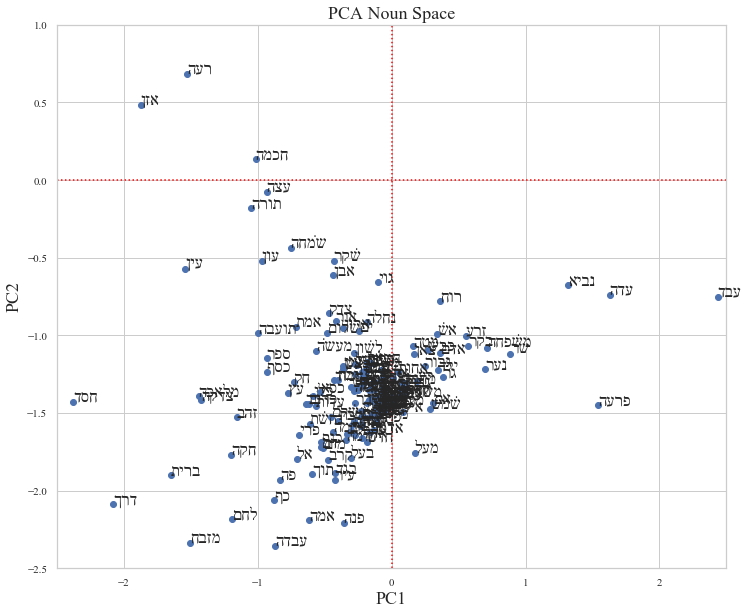

In [50]:
plot_PCA(pca_nouns, zoom=((-2.5, 2.5, -2.5, 1)), save='plots/PCA_main.png')

Note that nouns in the lower right quadrant tend to be people, while on the lower left there are primarily things.

The plot below shows person nouns.

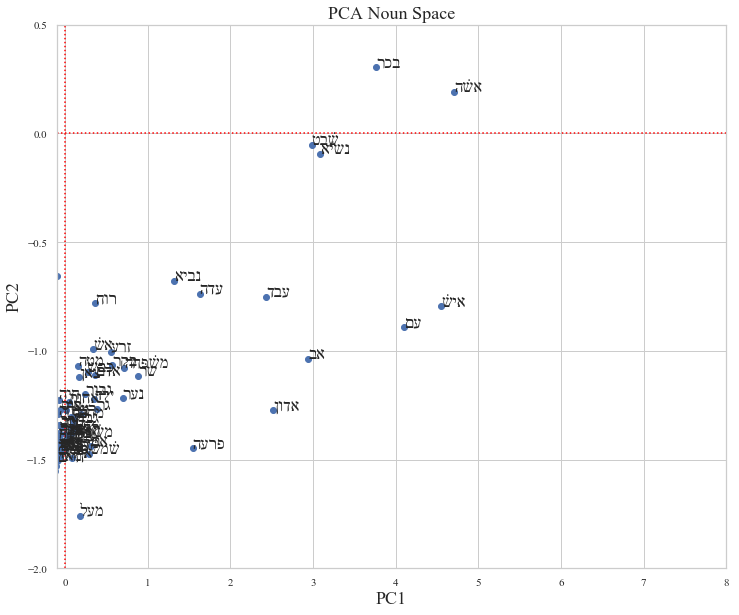

In [51]:
plot_PCA(pca_nouns, zoom=((-0.1, 8, -2, 0.5)))

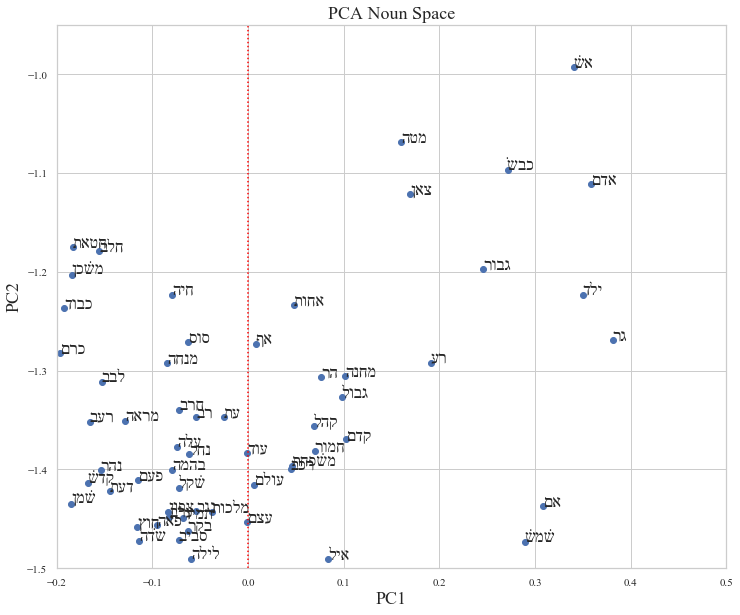

In [52]:
plot_PCA(pca_nouns, zoom=((-0.2, 0.5, -1.5, -0.95)))

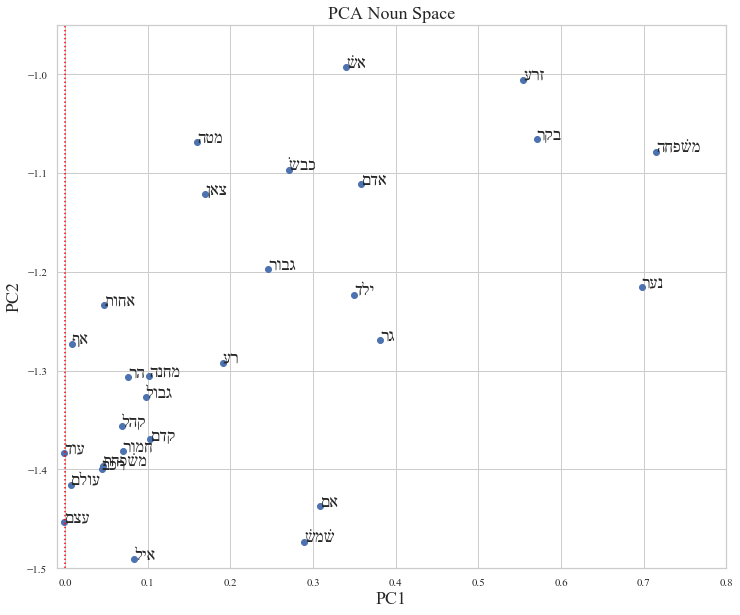

In [53]:
plot_PCA(pca_nouns, zoom=((-0.01, 0.8, -1.5, -0.95)))

Let's see what nouns to the right of the y axis have most in common. This could corroborate the intuition that the nouns on the right are personal.

First we isolate the nouns with a x-axis value > 0. Those are shown below, they are obviously personal nouns.

In [54]:
nouns_xy = pd.DataFrame.from_dict(pca_nouns_xy, orient='index', columns=['x', 'y'])
possibly_animate = nouns_xy[nouns_xy.x > 0]

In [55]:
for i, noun in enumerate(possibly_animate.sort_values(ascending=False, by='x').index):
    noun_node = counts.target2lex[noun]
    print(f'{T.text(noun_node)} "{F.gloss.v(noun_node)}" ({round(possibly_animate.loc[noun]["x"], 2)})')

בֵּן  "son" (197.71)
בַּת  "daughter" (25.34)
אָח  "brother" (11.73)
כֹּהֵן  "priest" (10.87)
פַּר  "young bull" (9.61)
מֶלֶךְ  "king" (9.5)
אִשָּׁה  "woman" (4.71)
אִישׁ  "man" (4.55)
עַם  "people" (4.1)
בְּכֹר  "first-born" (3.77)
נָשִׂיא  "chief" (3.09)
שֵׁבֶט  "rod" (2.98)
אָב  "father" (2.94)
אָדֹון  "lord" (2.52)
עֶבֶד  "servant" (2.44)
עֵדָה  "gathering" (1.63)
פַּרְעֹה  "pharaoh" (1.54)
נָבִיא  "prophet" (1.31)
שַׂר  "chief" (0.88)
מִשְׁפָּחָה  "clan" (0.71)
נַעַר  "boy" (0.7)
בָּקָר  "cattle" (0.57)
זֶרַע  "seed" (0.55)
גֵּר  "sojourner" (0.38)
רוּחַ  "wind" (0.36)
אָדָם  "human, mankind" (0.36)
יֶלֶד  "boy" (0.35)
אֵשׁ  "fire" (0.34)
אֵם  "mother" (0.31)
שֶׁמֶשׁ  "sun" (0.29)
כֶּבֶשׂ  "young ram" (0.27)
גִּבֹּור  "vigorous" (0.25)
רֵעַ  "fellow" (0.19)
מַעַל  "top" (0.18)
צֹאן  "cattle" (0.17)
מַטֶּה  "staff" (0.16)
קֶדֶם  "front" (0.1)
מַחֲנֶה  "camp" (0.1)
גְּבוּל  "boundary" (0.1)
אַיִל  "ram, despot" (0.08)
הַר  "mountain" (0.08)
חֲמֹור  "he-ass" (0.07)
קָהָל  "assembly" 

Now we find the context tags that are highest in the set. We pull the fourth quartile (75th percentile) of the context tags to see which ones are most shared accross these nouns.

In [56]:
def lex2node(lex_string, lexeme=False):
    lex = next((lex for lex in F.otype.s('lex') if F.lex.v(lex) == lex_string), 0)
    if not lexeme:
        return next((l for l in L.d(lex, 'word')), 0)
    else:
        return lex

def makePrettyTag(tag_string):
    '''
    This ugly piece of code is needed 
    to back-convert my context tags with
    ETCBC transcription into Hebrew characters.
    '''
    verb = True if tag_string.endswith('[') else False
    side1, side2 = tag_string.split('->')
    function, lex = side1.split('.')
    if verb:
        stem, verb = side2.split('.')
        function, lex, stem, verb = function.strip(), lex.strip(), stem.strip(), verb.strip()
        lex, verb = lex2node(lex), lex2node(verb)    
        tag = f'{function}.{F.lex_utf8.v(lex)}-> {stem}.{F.lex_utf8.v(verb)}'
    elif not tag_string.endswith('.') and lex:
        lex1, lex2 = lex.strip(), side2.strip()
        tag = re.sub(lex1, F.lex_utf8.v(lex2node(lex2)), tag_string)
        tag = re.sub(lex2, F.lex_utf8.v(lex2node(lex1)), tag)
        tag = re.sub('-> ', ' <-', tag)
    elif not lex:
        lex2 = side2.strip()
        tag = re.sub(lex2, F.lex_utf8.v(lex2node(lex2)), tag_string)
    else:
        lex1 = lex.strip()
        tag = re.sub(lex1, F.lex_utf8.v(lex2node(lex1)), tag_string)
    return tag.replace('None', '')

In [57]:
makePrettyTag('par.-> MYWH/')

'par.-> מצוה'

In [58]:
top_animate = fishertransf[possibly_animate.index].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

for tag in top_animate.index:
    print(f'({round(top_animate[tag], 2)}) {makePrettyTag(tag)}')

(1.04) Objc.-> qal.לקח
(1.03) Cmpl.אל-> qal.אמר
(0.92) Subj.-> qal.בוא
(0.9) Cmpl.ל-> qal.נתן
(0.84) Cmpl.ל-> qal.אמר
(0.75) Subj.-> qal.יצא
(0.63) Subj.-> qal.אמר
(0.6) Subj.-> qal.שׁמע
(0.57) Cmpl.ל-> qal.עשׂה
(0.55) Subj.-> qal.מות
(0.54) Subj.-> qal.עשׂה
(0.54) Subj.-> qal.קום
(0.52) Subj.-> qal.לקח
(0.52) Subj.-> qal.עלה
(0.49) Subj.-> qal.הלך


Verbs are the greatest distinguishing factor here, with אמר, בוא,נתן, לקח and others serving a big role. מות "die" also plays a role.

Below we pull the tendencies for the nouns with a PC1 < 0. These nouns appear to be impersonal in nature.

In [59]:
possibly_inanimate = nouns_xy[nouns_xy.x < 0]
inanimate_features = fishertransf[possibly_inanimate.index].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

for tag in inanimate_features.index:
    print(f'({round(inanimate_features[tag], 2)}) {makePrettyTag(tag)}')

(0.53) Objc.-> qal.עשׂה
(0.44) Objc.-> qal.שׂים
(0.41) Objc.-> qal.נתן
(0.25) Objc.-> qal.ראה
(0.0) Loca.ב-> nif.ילד
(0.0) Loca.ב-> nif.שׁמע
(0.0) Loca.ב-> nif.שׁאר
(0.0) Loca.ב-> nif.ברא
(0.0) Loca.ב-> nif.עשׂה
(0.0) Loca.ב-> hit.חנן
(0.0) Loca.ב-> hit.נבא
(0.0) Loca.ב-> hif.מלך
(0.0) Loca.ב-> hif.נוח
(0.0) Loca.ב-> hif.נפל
(0.0) Loca.ב-> hif.נכה


Clearly these scores are more consistent with impersonal nouns. With object roles to the verbs עשה, נתן, and שים. 

The next plot shows nouns to the left of the y-origin. Note especially the terms between y(-0.5) and y(0.0.). These are more conceptual nouns. This same trajectory extends up into the far parts of the upper left quadrant through דבר and קול.

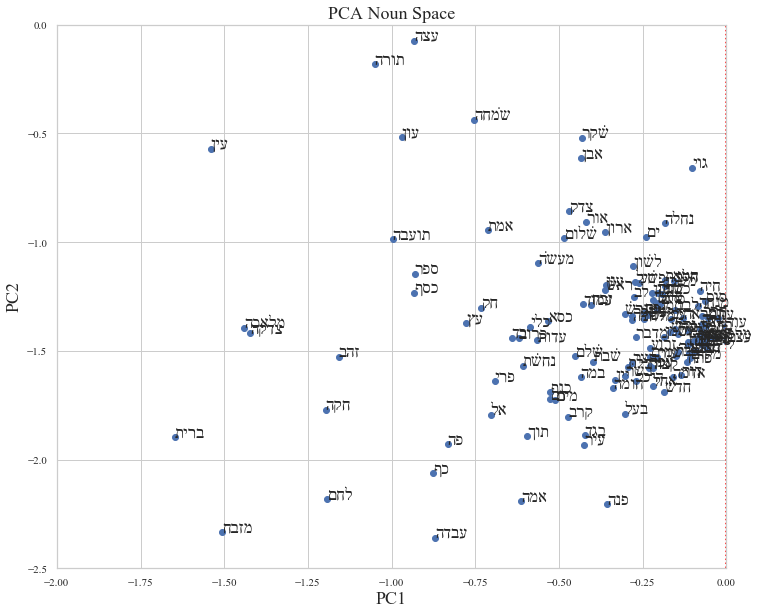

In [64]:
plot_PCA(pca_nouns, zoom=((-2, 0, -2.5, 0)))

Here is a closer look at the larger cluster near the left side of the y-origin.

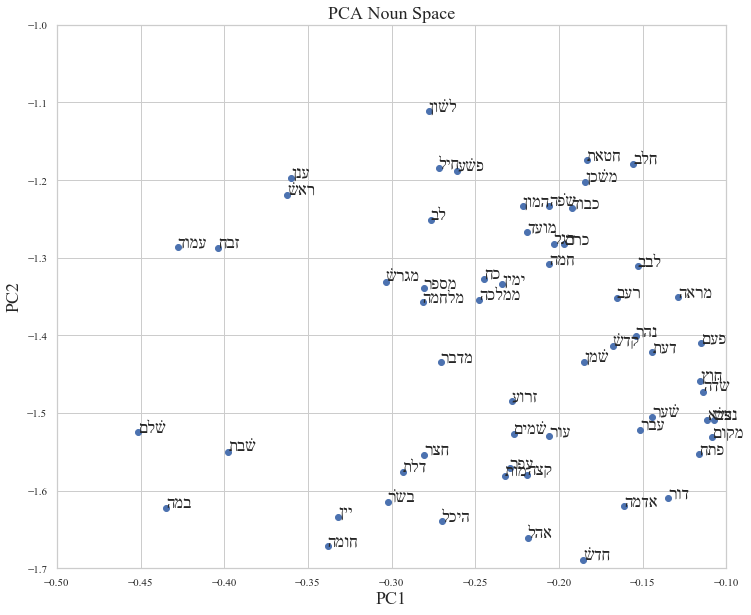

In [65]:
plot_PCA(pca_nouns, zoom=((-0.5, -0.1, -1.7, -1)))

Some important tendencies emerge in the PCA plot. In general, person-nouns tend to fall to the right of the vertical axis while things and ideas fall on the left.

### Cosine Similarity Rankings

In [66]:
distances_raw = pairwise_distances(fishertransf.T.values, metric='cosine')
distances = pd.DataFrame(distances_raw, columns=fishertransf.columns, index=fishertransf.columns)
similarities = distances.apply(lambda n: 1-n) # convert distance matrix to similarities.

### Make Subplots

Below we visualize the top 5 similarity scores for all of the nouns.

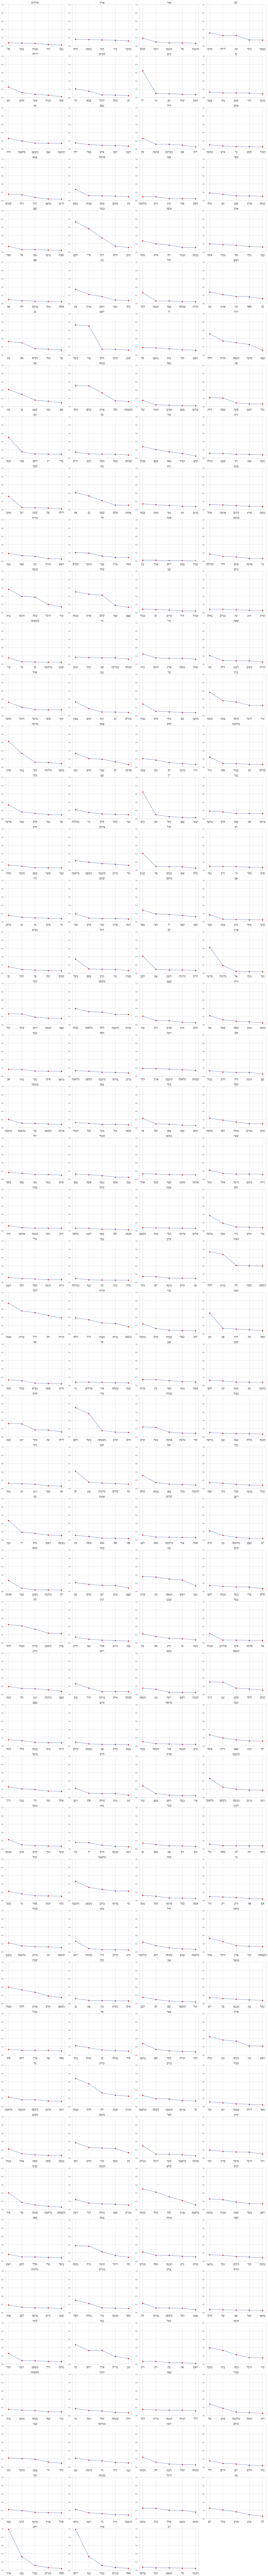

In [67]:
plt.figure(figsize=(22, 210))

for i, noun in enumerate(similarities.columns):
    
    sims = similarities[noun].sort_values(ascending=False).head(6)[1:]
    sim_values = sims.values
    lexemes = [reverse_hb(F.lex_utf8.v(counts.target2node[noun])) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    sims_new = pd.DataFrame(sim_values, index=lex_glosses)
    
    # make plots
    x = np.arange(sims.shape[0])
    plt.subplot(50,4,i+1)
    plt.plot(sims_new.values)
    plt.scatter(x=x, y=sims_new.values, color='red')
    plt.title(f'{reverse_hb(F.lex_utf8.v(counts.target2node[noun]))}', size=20)
    plt.xticks(x, lexemes, size=20)
    plt.ylim(0, 1)
    
    
plt.tight_layout()

Export an example for the presentation, נחשׁת "copper", the result of which is improved in the semantic network experiment further below.

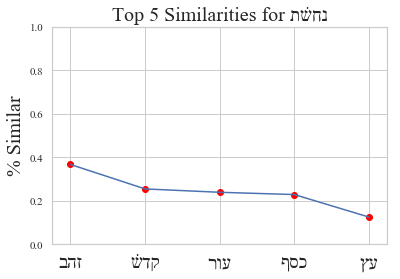

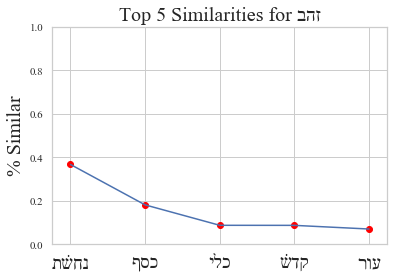

In [71]:
save_figs = ['NXCT/', 'ZHB/']

for noun in save_figs:
    sims = similarities[noun].sort_values(ascending=False).head(6)[1:]
    sim_values = sims.values
    lexemes = [reverse_hb(F.lex_utf8.v(counts.target2node[noun])) for noun in sims.index]
    glosses = [counts.target2gloss[noun] for noun in sims.index]
    lex_glosses = [f'{lex} \'{gloss}\'' for lex, gloss in zip(lexemes, glosses)]
    noun_text = F.lex_utf8.v(counts.target2node[noun])
    
    # make plots
    x = np.arange(sims.shape[0])
    plt.plot(sim_values)
    plt.scatter(x=x, y=sim_values, color='red')
    plt.title(f'Top 5 Similarities for {reverse_hb(noun_text)}', size=20)
    plt.xticks(x, lexemes, size=20)
    plt.ylabel('% Similar', size=20)
    plt.ylim(0, 1)
    plt.savefig(f'plots/similarity_{noun_text}', dpi=300, bbox_inches='tight')
    plt.show()

Look at the commonalities between bronze and holiness, skin, and work.

In [72]:
surprising_bronze = fishertransf[['NXCT/', 'QDC/', 'ML>KH/', '<WR=/']]

surprising_bronze.quantile(0.75, axis=1).sort_values(ascending=False).head(15)

rec.-> KLJ/              14.706411
Objc.-> qal.<FH[          7.685233
rec.>JL=/-> .             7.462230
Subj.-> nif.<FH[          5.097901
Cmpl.B-> qal.PFH[         4.826207
rec.-> ML>KT/             4.372635
Cmpl.BJN/-> hif.BDL[      2.298352
par.<Y/-> .               2.263986
Cmpl.L-> nif.<FH[         2.175114
Para.-> KSP/              2.103060
PreC.L. -> Subj.MCQL/     2.024441
par.<WR=/-> .             1.839171
Adju.B-> qal.<FH[         1.802957
Objc.-> piel.XLL[         1.751788
par.-> <WR=/              1.652513
Name: 0.75, dtype: float64

In [73]:
expected_bronze = fishertransf[['NXCT/', 'KSP/', 'ZHB/']]

expected_bronze.quantile(0.75, axis=1).sort_values(ascending=False).head(15)

par.ZHB/-> .          27.203231
par.-> KSP/           26.053774
Objc.-> piel.YPH=[    24.734014
rec.-> KKR/           23.145140
rec.-> KLJ/           18.981890
rec.-> VB<T/          14.503250
atr.VHR/-> .          13.152790
Objc.-> qal.NTN[       9.921244
par.KSP/-> .           9.238590
par.-> ZHB/            9.019778
Cmpl.-> piel.YPH=[     7.989666
PreC.-> Subj.WW/       6.858160
Objc.-> qal.CQL[       6.582767
Objc.-> qal.<FH[       5.752549
Adju.B-> qal.QNH[      4.943916
Name: 0.75, dtype: float64

## Gephi Network Visualization

The plots above are helpful for looking at individual words and their top similar terms, but they do not really give a sense of the bigger picture, nor of the connections between terms. For instance, רחב and ארך both share a connection as each others' top most common noun. But this relationship  between the terms, and their mutual relationship to other terms, cannot be clearly seen.

We can better visualize word relationships by graphing them as nodes connected by edges in a semantic network. The similarity scores can be used to give weight to the edges. A visual plotting studio like [Gephi](www.gephi.org) can then be used to plot the nodes and edges into a visual space.

There are a couple of challenges to overcome before the nodes and edges can be exported for Gephi. The most important issue is how to decide which edges are exported? It is not ideal to plot 199x199 edges, and at any rate not all noun x noun comparisons have positive similarities (indeed many have negative values). This simplifies, at least, one aspect of the edge selection: we weed out all relationships that have negative similarity scores. Below, the number of positive similarity ratings per noun are shown.

In [74]:
for lex in similarities.columns:
    positives = similarities[lex][similarities[lex] > 0]
    print(lex, positives.shape[0])

>LHJM/ 13
>RY/ 116
>WR/ 173
JWM/ 81
LJLH/ 111
CMJM/ 159
MJM/ 151
JM/ 183
<Y/ 155
NPC/ 165
XJH/ 163
>DM/ 187
YB>/ 168
>DMH/ 160
PNH/ 108
<PR/ 166
CM/ 129
BFR/ 160
>CH/ 133
>JC/ 104
>M/ 135
<JN/ 145
QWL/ 105
R>C/ 169
BN/ 48
LXM/ 128
JD/ 105
DRK/ 142
>X/ 139
MNXH/ 158
M>D/ 23
PH/ 149
DM/ 166
KX/ 174
<WD/ 140
ZR</ 178
CNH/ 78
BT/ 130
RWX/ 179
PTX/ 158
BRJT/ 150
HR/ 143
>MH=/ 30
BHMH/ 175
MZBX/ 145
<LH/ 127
<NN/ 135
KRM/ 141
MCPXH/ 142
GWJ/ 168
<JR/ 139
FPH/ 168
>HL/ 162
NGB/ 80
FR/ 151
BJT/ 123
PR<H/ 119
YPWN/ 69
QDM/ 36
MLXMH/ 161
MLK/ 66
<M/ 113
JJN/ 168
N<R/ 150
XWY/ 159
YDQH/ 132
>JL=/ 149
R<=/ 168
DWR/ 156
CMC/ 123
ML>K/ 111
>B/ 107
NFJ>/ 132
RGL/ 181
LB/ 164
>DWN/ 110
DBR/ 121
MCPV/ 122
P<M/ 87
DLT/ 145
<BD/ 131
XSD/ 112
R<H/ 165
>C/ 171
M<FH/ 150
Y>N/ 159
BQR/ 159
KSP/ 135
JLD/ 154
XMWR/ 155
MQWM/ 167
C<R/ 148
FDH/ 155
CQL/ 104
>MT/ 151
ZHB/ 134
KLJ/ 162
BGD/ 161
<RB/ 91
MYWH/ 121
XQH/ 146
TWRH/ 172
<WR=/ 125
XMH/ 171
>P/ 172
>L/ 146
>BN/ 169
CMN/ 154
XDC=/ 129
PRJ/ 149
<BDH/ 183
KB

The best cut-off point for edge values is the point of maximum curvature, known as the "knee" or in this case, an "elbow". `kneed` is an algorithm that automatically detects this point ([here](https://github.com/arvkevi/kneed)). The detector is demonstrated below, where the red lines are the detected elbows. These points will be used as the cut-off point for edge exports.

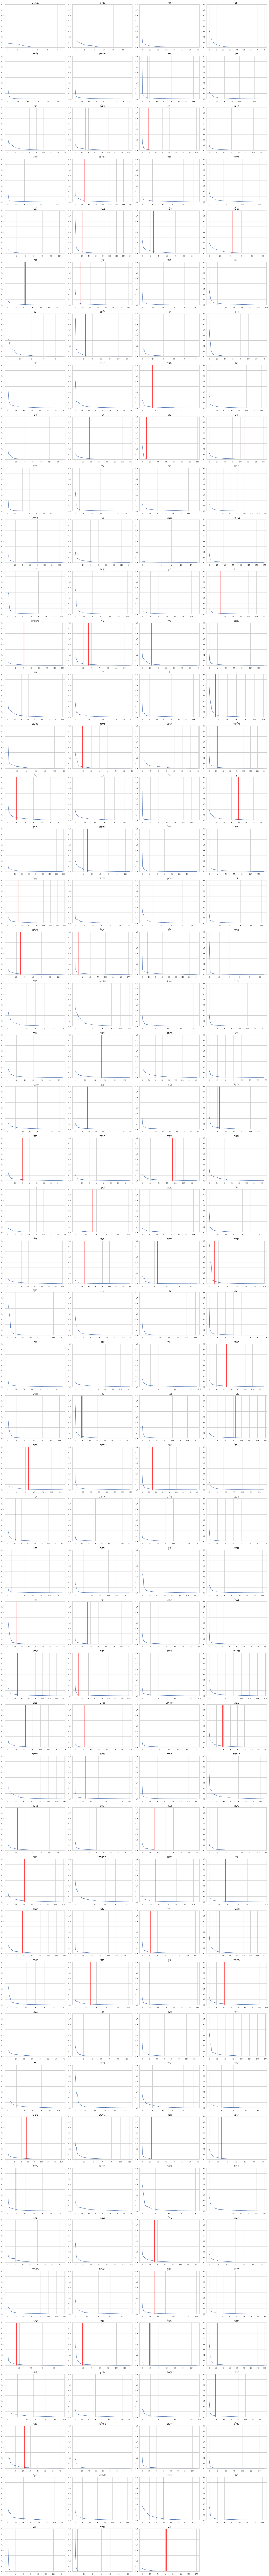

In [76]:
plt.figure(figsize=(22, 210))

for i, noun in enumerate(similarities.columns):
    
    sims = similarities[noun][similarities[noun] > 0].sort_values(ascending=False)[1:]
    
    x = np.arange(sims.shape[0])
    y = sims.values
    
    # detect elbow
    elbow = KneeLocator(x, y, curve='convex', direction='decreasing').knee
    
    # make plots
    plt.subplot(50,4,i+1)
    plt.plot(x, y)
    plt.title(f'{reverse_hb(F.lex_utf8.v(counts.target2node[noun]))}', size=20)
    plt.ylim(0, 0.8)
    plt.axvline(elbow, color='red')
plt.tight_layout()

### Export Elbow Edges

Use `kneed` to detect the ideal edge cut-off point.

In [77]:
node_maps = {}
nodes = []
edges = []

# make nodes
ID = 0
for noun in similarities:
    label = F.lex_utf8.v(counts.target2node[noun])
    nodes.append([ID, label])
    node_maps[noun] = ID
    ID += 1

# make edges
for noun in similarities.columns:
    positive_sims = similarities[noun][similarities[noun] > 0].sort_values(ascending=False)[1:]
    
    # detect elbow
    x = np.arange(positive_sims.shape[0])
    y = positive_sims.values
    elbow = KneeLocator(x, y, curve='convex', direction='decreasing').knee   
    edge_sims = positive_sims.head(elbow)
    for conoun in edge_sims.index:
        source = node_maps[noun]
        target = node_maps[conoun]
        weight = similarities[noun][conoun]
        edges.append([source, target, weight])

# export csv's
with open('gephidata/sim_nodes_elbows.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['ID', 'Label'])
    writer.writerows(nodes)

with open('gephidata/sim_edges_elbows.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Source', 'Target', 'Weight'])
    writer.writerows(edges)

# TODO: Re-run Gephi with corrected data and import new images

The results presented below will change slightly since I have found some mistakes in the context parameters. To be fixed soon. -C, 29 Dec 2018

## Gephi Results

Below the results of the gephi graph are displayed. Force-Atlas was used to arrange the nodes. The results show discernible neighborhoods of similar nouns.

<img src="gephidata/graphs/full_graph.png">

## Examining Semantic Networks

Below we look closer at the neighborhoods found in the semantic network. Specifically, we want to see what features give rise to the similarities that are registered.

### Group 1

<img src="gephidata/graphs/group1.png">

In [64]:
group1_targets = ['XQ/', 'CBT/', 'TWRH/', 'MYWH/', 
                  'XQH/', '<DWT/', 'MCPV/']

group1_tendencies = fishertransf[group1_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

for tag in group1_tendencies.index:
    print(f'{round(group1_tendencies[tag], 2)}\t{makePrettyTag(tag)}')

26.63	Objc.-> qal.שׁמר
6.63	par.משׁפט-> .
6.61	par.-> מצוה
6.47	Cmpl.ב-> qal.הלך
4.49	Objc.-> qal.עשׂה
4.09	par.חק-> .
3.63	par.מצוה-> .
3.31	par.-> חק
2.93	Para.-> מצוה
2.6	par.-> חקה
2.43	par.תורה-> .
2.39	Objc.-> qal.עזב
2.32	Objc.-> qal.נצר
2.06	Adju.כ-> qal.עשׂה
1.95	PreC.שׁעשׁועים-> Subj.


### Group 2

<img src="gephidata/graphs/group2.png">

In [65]:
group2_targets = ['MXNH/', '>HL/', 'HJKL/', '<JR/', 
                  'BJT/', 'XWMH/', 'BMH/', 'MZBX/']

group2_tendencies = fishertransf[group2_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

for tag in group2_tendencies.index:
    print(f'{round(group2_tendencies[tag], 2)}\t{makePrettyTag(tag)}')

22.48	Objc.-> qal.בנה
10.94	Cmpl.אל-> qal.בוא
4.4	Cmpl.-> qal.בוא
4.34	Objc.-> qal.נתץ
4.32	Cmpl.ב-> qal.ישׁב
2.36	Cmpl.מן-> qal.יצא
2.19	Cmpl.-> qal.עלה
2.1	Objc.-> qal.הרס
2.01	Subj.-> nif.בנה
1.75	Objc.-> qal.שׂרף
1.66	Para.בית-> .
1.61	Cmpl.אל-> qal.שׁוב
1.56	Cmpl.מן-> hif.יצא
1.48	Cmpl.אל-> hif.בוא
1.47	Loca.בין-> qal.נתן


### Group 3

<img src="gephidata/graphs/group3.png">

In [66]:
group3_targets = ['BT/', '>X/', 'BN/']

group3_tendencies = fishertransf[group3_targets].quantile(0.75, axis=1).sort_values(ascending=False).head(15)

for tag in group3_tendencies.index:
    print(f'{round(group3_tendencies[tag], 2)}\t{makePrettyTag(tag)}')

66.62	par.-> בן
57.82	par.בן-> .
48.13	Appo.בן-> .
47.93	Appo.-> בן
30.67	par.בת-> .
26.6	Objc.-> qal.ילד
25.97	Objc.-> hif.ילד
22.67	Para.מעל-> .
15.55	Cmpl.אל-> piel.דבר
12.49	par.אח-> .
12.21	Appo.-> יהושׁע
11.34	Appo.כהן-> .
8.81	Appo.-> שׁלמה
8.44	Appo.-> בניהו
8.32	par.-> אהרן


<hr>